In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [31]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [32]:
#Importing data from file

def import_data():
    df = pd.read_excel('dat/anuro_ppf.xls', sheet_name='PPF_margins', usecols='A:J')

    pdur = df['PDUR'].values
    ppau = df['PPAU'].values
    phonotaxis = df['rXY'].values

    dur_max = 20  # ms
    dur_step = 0.5  # ms
    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T
    # points = np.array([pdur, ppau]).T
    

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))
    
    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    # print(np.any(np.isnan(new_points)))
    
    ppf /= np.max(ppf)
    
    return ppf

In [33]:
dur_max = 20  # ms
dur_step = 0.5  # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data()
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

In [38]:
# np.sqrt(np.mean((pnt_ori)**2))

In [5]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [49]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t) # in KHz, ms
    gbr =  gaussian * sinusoidal
    return gbr

# def gabor(fr, sigma, phi, w, sf):  *  np.exp(-(t)**2/(2*sigma**2))
#     border = sigma + int(1/sigma)
#     t =  np.arange(-border, border, 1/sf)/1000
#     gbr = ((np.exp( -(t/2*sigma)**2)) * (np.sin((2*mt.pi*fr*t) + phi)) + w) #Gabor function
#     return gbr

# gab = gabor(50, 10, 0, 0, 2000)
# print(gab/1000, len(gab))
# plt.figure(figsize = (30, 10))
# plt.plot(gab)
# # plt.xlim(xmin=400,xmax=700)
# plt.show()

In [7]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [8]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [173]:
def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [112]:
#the entire thing a a function

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [114]:
#the entire thing a a function

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

In [33]:
#bounds

b_fr = (100, 200)
b_sigma = (1, 101)
b_phi = (0, 2)
b_w = (-0.1, 0.1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


In [34]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [145]:
cfg = [120, 7, 0, 0, 0.04, 0.02]
y = sig_diff(cfg)
print(y)


0.1353713008349576


In [178]:
diff_list = []
min_diff = []
xa = 1

np.random.seed(int(time.time()))
for i in range(1, 15):
    rfr = np.random.uniform(100, 130)
    rsigma = np.random.uniform(1,10)
    rphi = np.random.uniform(0,2)
    rw = np.random.uniform(-0.1, 0.1)
    ra1 = np.random.uniform(0,0.3)
    rb1 = np.random.uniform(0, 0.3)
    cfg = [rfr, rsigma, rphi, rw, ra1, rb1]
    print(i)
    result = spo.minimize(sig_diff, cfg, options = {"disp": True},  bounds = bnds, method = 'Nelder-Mead')
    if result.success:
        print("Success!")
        print(result)
        diff_list.append(result)
        if result.fun < xa:
            xa = result.fun
            min_diff = result
    else:
        print("Sorry, could not find a minimum.")

1
Optimization terminated successfully.
         Current function value: 0.113664
         Iterations: 560
         Function evaluations: 907
Success!
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11366429293761961
             x: [ 1.153e+02  9.429e+00  5.102e-01  9.984e-02  7.280e-02
                  2.816e-02]
           nit: 560
          nfev: 907
 final_simplex: (array([[ 1.153e+02,  9.429e+00, ...,  7.280e-02,
                         2.816e-02],
                       [ 1.153e+02,  9.429e+00, ...,  7.280e-02,
                         2.816e-02],
                       ...,
                       [ 1.153e+02,  9.429e+00, ...,  7.280e-02,
                         2.816e-02],
                       [ 1.153e+02,  9.429e+00, ...,  7.280e-02,
                         2.816e-02]]), array([ 1.137e-01,  1.137e-01,  1.137e-01,  1.137e-01,
                        1.137e-01,  1.137e-01,  1.137e-01]))
2


/tmp/ipykernel_3649/3202684848.py:15: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = spo.minimize(sig_diff, cfg, options = {"disp": True},  bounds = bnds, method = 'Nelder-Mead')


Sorry, could not find a minimum.
3
Optimization terminated successfully.
         Current function value: 0.117601
         Iterations: 279
         Function evaluations: 501
Success!
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11760061685915961
             x: [ 1.154e+02  7.703e+00  2.000e+00 -8.357e-02  6.381e-06
                  5.931e-02]
           nit: 279
          nfev: 501
 final_simplex: (array([[ 1.154e+02,  7.703e+00, ...,  6.381e-06,
                         5.931e-02],
                       [ 1.154e+02,  7.703e+00, ...,  6.435e-06,
                         5.931e-02],
                       ...,
                       [ 1.154e+02,  7.703e+00, ...,  5.780e-06,
                         5.931e-02],
                       [ 1.154e+02,  7.703e+00, ...,  5.674e-06,
                         5.931e-02]]), array([ 1.176e-01,  1.176e-01,  1.176e-01,  1.176e-01,
                        1.176e-01,  1.176e-01,  1.17

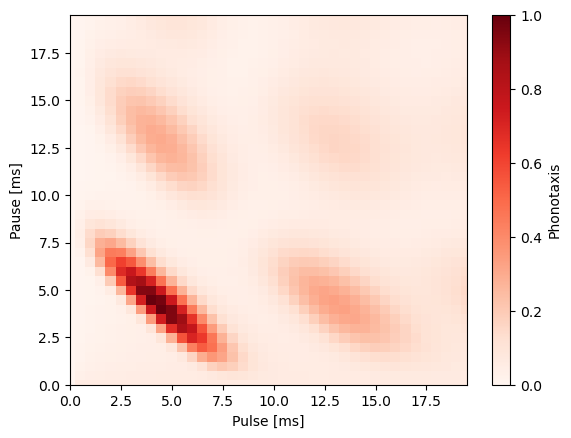

2.0679071684945316e-05


In [186]:
x2 = sig_diff2(min_diff.x)
plot_field(pdur_i, ppau_i, x2[1])
print(min_diff.fun - finallllly3[0].fun)


[0.11335649538470557, 3]


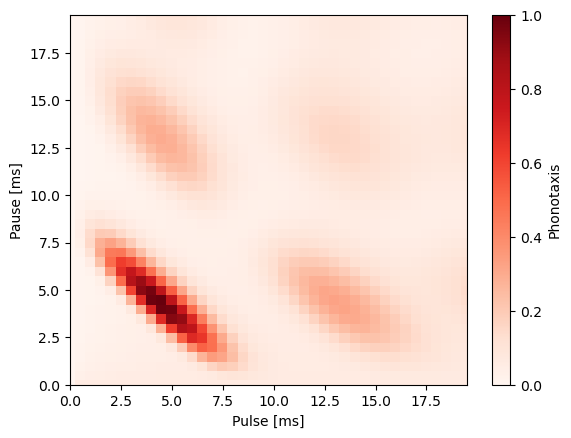

In [177]:
mino = [1,0]
for i in range(0,len(diff_list)):
    if diff_list[i].fun < mino[0]:
        mino = [diff_list[i].fun, i]
print(mino)

xx = sig_diff2(diff_list[3].x)
plot_field(pdur_i, ppau_i, xx[1])

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11861833553371347
             x: [ 1.167e+02  7.406e+00  0.000e+00  4.624e-02  2.524e-02
                  8.875e-02]
           nit: 556
          nfev: 913
 final_simplex: (array([[ 1.167e+02,  7.406e+00, ...,  2.524e-02,
                         8.875e-02],
                       [ 1.167e+02,  7.406e+00, ...,  2.523e-02,
                         8.876e-02],
                       ...,
                       [ 1.167e+02,  7.406e+00, ...,  2.523e-02,
                         8.875e-02],
                       [ 1.167e+02,  7.406e+00, ...,  2.523e-02,
                         8.876e-02]]), array([ 1.186e-01,  1.186e-01,  1.186e-01,  1.186e-01,
                        1.186e-01,  1.186e-01,  1.186e-01]))]


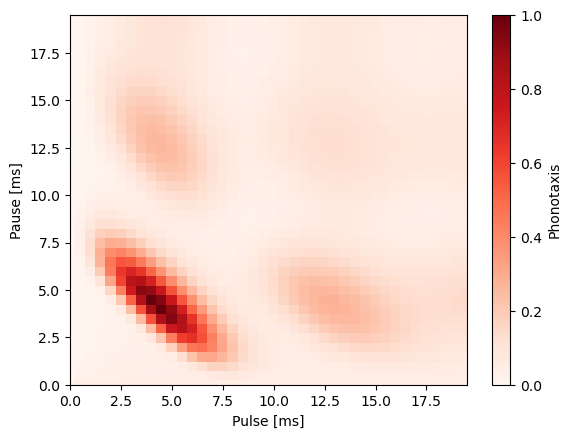

In [147]:
finallllly4 = diff_list
print(finallllly4)
xe = sig_diff2(finallllly4[0].x)
plot_field(pdur_i, ppau_i, xe[1])

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11317821432500454
             x: [ 1.137e+02  1.171e+01  1.871e-05 -1.970e-03  9.072e-02
                  9.759e-03]
           nit: 533
          nfev: 861
 final_simplex: (array([[ 1.137e+02,  1.171e+01, ...,  9.072e-02,
                         9.759e-03],
                       [ 1.137e+02,  1.171e+01, ...,  9.072e-02,
                         9.760e-03],
                       ...,
                       [ 1.137e+02,  1.171e+01, ...,  9.072e-02,
                         9.759e-03],
                       [ 1.137e+02,  1.171e+01, ...,  9.072e-02,
                         9.759e-03]]), array([ 1.132e-01,  1.132e-01,  1.132e-01,  1.132e-01,
                        1.132e-01,  1.132e-01,  1.132e-01]))]


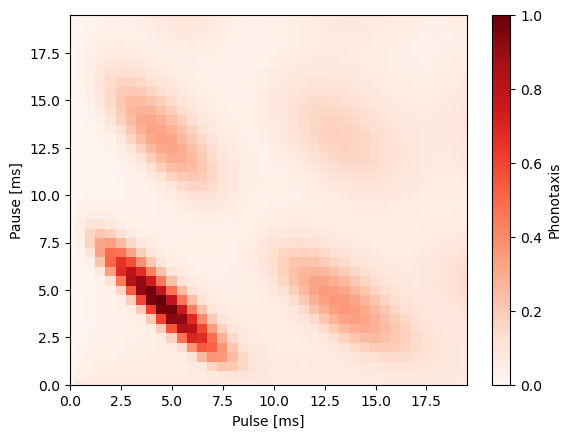

In [140]:
finallllly3 = diff_list
print(finallllly3)
xd = sig_diff2(finallllly3[0].x)
plot_field(pdur_i, ppau_i, xd[1])

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11325823363869397
             x: [ 1.148e+02  1.171e+01  0.000e+00  4.130e-02  9.500e-02
                  1.084e-02]
           nit: 533
          nfev: 861
 final_simplex: (array([[ 1.148e+02,  1.171e+01, ...,  9.500e-02,
                         1.084e-02],
                       [ 1.148e+02,  1.171e+01, ...,  9.500e-02,
                         1.084e-02],
                       ...,
                       [ 1.148e+02,  1.171e+01, ...,  9.500e-02,
                         1.084e-02],
                       [ 1.148e+02,  1.171e+01, ...,  9.501e-02,
                         1.084e-02]]), array([ 1.133e-01,  1.133e-01,  1.133e-01,  1.133e-01,
                        1.133e-01,  1.133e-01,  1.133e-01]))]


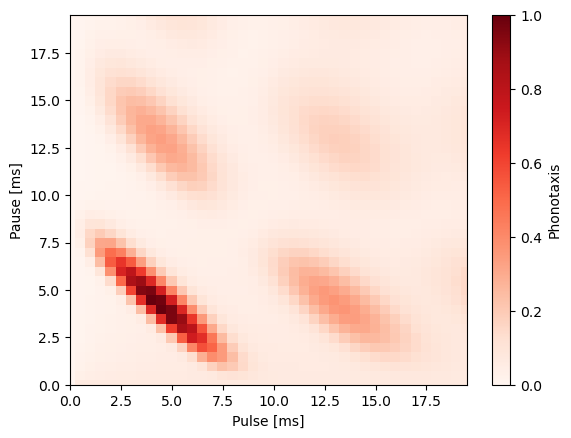

In [128]:
finallllly2 = diff_list
print(finallllly2)
xc = sig_diff2(finallllly2[0].x)
plot_field(pdur_i, ppau_i, xc[1])

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11402257234623511
             x: [ 1.154e+02  9.143e+00  0.000e+00 -2.286e-04  6.441e-02
                  1.675e-02]
           nit: 384
          nfev: 637
 final_simplex: (array([[ 1.154e+02,  9.143e+00, ...,  6.441e-02,
                         1.675e-02],
                       [ 1.154e+02,  9.143e+00, ...,  6.441e-02,
                         1.675e-02],
                       ...,
                       [ 1.154e+02,  9.143e+00, ...,  6.441e-02,
                         1.675e-02],
                       [ 1.154e+02,  9.143e+00, ...,  6.442e-02,
                         1.675e-02]]), array([ 1.140e-01,  1.140e-01,  1.140e-01,  1.140e-01,
                        1.140e-01,  1.140e-01,  1.140e-01]))]


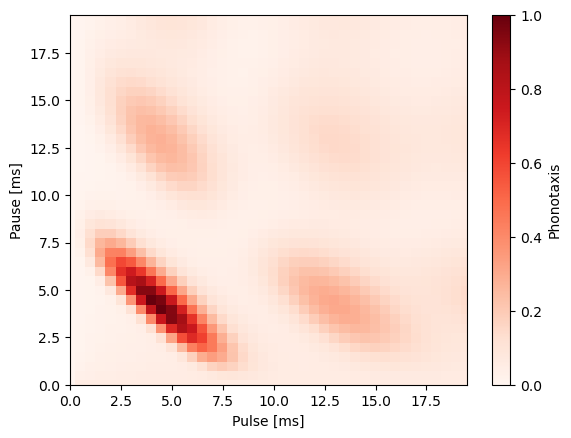

In [134]:
finallllly1 = diff_list
print(finallllly1)
xb = sig_diff2(finallllly1[0].x)
plot_field(pdur_i, ppau_i, xb[1])

[       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.11402257236626877
             x: [ 1.154e+02  9.143e+00  0.000e+00  1.475e-03  6.441e-02
                  1.675e-02]
           nit: 320
          nfev: 545
 final_simplex: (array([[ 1.154e+02,  9.143e+00, ...,  6.441e-02,
                         1.675e-02],
                       [ 1.154e+02,  9.143e+00, ...,  6.442e-02,
                         1.675e-02],
                       ...,
                       [ 1.154e+02,  9.143e+00, ...,  6.441e-02,
                         1.675e-02],
                       [ 1.154e+02,  9.143e+00, ...,  6.441e-02,
                         1.675e-02]]), array([ 1.140e-01,  1.140e-01,  1.140e-01,  1.140e-01,
                        1.140e-01,  1.140e-01,  1.140e-01]))]


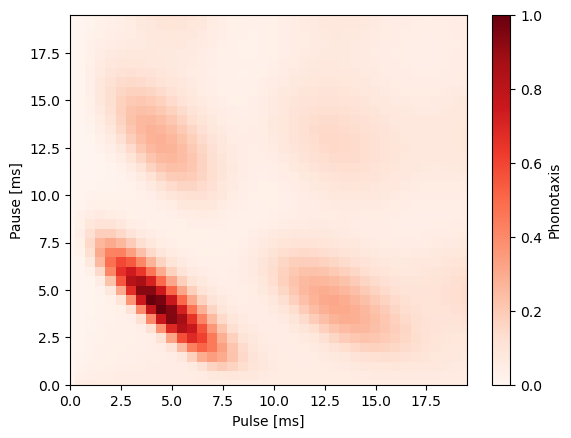

In [137]:
finallllly = diff_list
print(finallllly)
xa = sig_diff2(finallllly[0].x)
plot_field(pdur_i, ppau_i, xa[1])

In [142]:
print(xa[0]-xd[0])

0.0008443580412642315


In [100]:

# dl = np.array(diff_list)

# cfgx1 = np.array(dl[0].x)
# df, pn = sig_diff(cfgx1)
# plot_field(pdur_i, ppau_i, pn)


In [101]:

# np.random.seed(int(time.time()))
# for i in range(1, 11):
#     rfr = np.random.uniform(30, 200)
#     rsigma = np.random.uniform(30,101)
#     rphi = np.random.uniform(0,2)
#     rw = np.random.uniform(-0.1, 0.1)
#     ra1 = np.random.uniform(0,10)
#     rb1 = np.random.uniform(0, 10)
#     cfg = [rfr, rsigma, rphi, rw, ra1, rb1]

# # print(sig_diff(cfg))

# cfg1 = [1,0,0]
# for i in range(115, 130):
#     print(i)
#     for j in range(1, 50):
#         cfg = [i, j, 0, 0, 0.05, 1]
#         x = sig_diff(cfg)
        
#         if cfg1[0] > x:
#             cfg1 = [x, i, j]
    
# print(cfg1)

In [ ]:
# np.random.seed(int(time.time()))
# for i in range(1, 11):
#     rb1 = np.random.uniform(-np.inf, np.inf)
#     print(rb1)
    
# #(np.random.random() * 1000) % 40 + 30

In [ ]:
# Optimization terminated successfully.
#          Current function value: 0.034308
#          Iterations: 40
#          Function evaluations: 174
# Success!
#        message: Optimization terminated successfully.
#        success: True
#         status: 0
#            fun: 0.03430812552020526
#              x: [ 3.877e+01  6.817e+01  1.039e+00 -1.000e-01  0.000e+00
#                   4.564e+00]
#            nit: 40
#           nfev: 174
#  final_simplex: (array([[ 3.877e+01,  6.817e+01, ...,  0.000e+00,
#                          4.564e+00],
#                        [ 3.877e+01,  6.817e+01, ...,  0.000e+00,
#                          4.564e+00],
#                        ...,
#                        [ 3.877e+01,  6.817e+01, ...,  0.000e+00,
#                          4.564e+00],
#                        [ 3.877e+01,  6.817e+01, ...,  0.000e+00,
#                          4.564e+00]]), array([ 3.431e-02,  3.431e-02,  3.431e-02,  3.431e-02,
#                         3.431e-02,  3.431e-02,  3.431e-02]))

In [ ]:
# [       message: Optimization terminated successfully.
#        success: True
#         status: 0
#            fun: 0.11402257236626877
#              x: [ 1.154e+02  9.143e+00  0.000e+00  1.475e-03  6.441e-02
#                   1.675e-02]
#            nit: 320
#           nfev: 545
#  final_simplex: (array([[ 1.154e+02,  9.143e+00, ...,  6.441e-02,
#                          1.675e-02],
#                        [ 1.154e+02,  9.143e+00, ...,  6.442e-02,
#                          1.675e-02],
#                        ...,
#                        [ 1.154e+02,  9.143e+00, ...,  6.441e-02,
#                          1.675e-02],
#                        [ 1.154e+02,  9.143e+00, ...,  6.441e-02,
#                          1.675e-02]]), array([ 1.140e-01,  1.140e-01,  1.140e-01,  1.140e-01,
#                         1.140e-01,  1.140e-01,  1.140e-01]))]